# 5 Cross-Validation Techniques You Need To Create Models That People Trust
## TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@zen-chung?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Zen Chung</a>
        on 
        <a href='https://www.pexels.com/photo/crop-man-playing-with-dog-on-street-5749795/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels.</a> All images are by the author unless specified otherwise.
    </strong>
</figcaption>

# Setup

In [4]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import umap
import umap.plot
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import *
from sklearn.datasets import *
from sklearn.impute import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import *

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [62]:
X, y = make_regression(n_samples=100)

In [63]:
def visualize_cv(cv, X, y):
    fig, ax = plt.subplots(figsize=(10, 5))

    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        p1 = ax.scatter(tr, [ii] * len(tr), c="#221f1f", marker="_", lw=8)
        p2 = ax.scatter(tt, [ii] * len(tt), c="#b20710", marker="_", lw=8)
        ax.set(
            title=cv.__class__.__name__,
            xlabel="Data Index",
            ylabel="CV Iteration",
            ylim=[cv.n_splits, -1],
        )
        ax.legend([p1, p2], ["Training", "Validation"])

    plt.show()

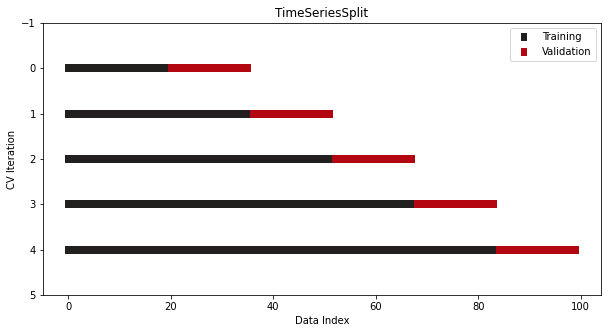

In [73]:
visualize_cv(TimeSeriesSplit(n_splits=5), X, y)

# Introduction

I'll be honest. These days I rarely cross-validate. Maybe it is because of the sheer size of the datasets I've been dealing with. Call me lazy, stupid or even pretentious *blank* for writing an article on something I am not even using. No matter what, one thing is for certain - I won't stop preaching the importance of cross-validation until I am blue in the face. 

What?! Are you confused? That's great - let's get started!

# Why cross-validate?

Until I start selling the related merchandise, I gotta advertise the main idea. Here it goes.

Let's imagine a world where you don't know what a CV procedure is. In that crazy world, you obviously split your available data into a single train and test sets. The model learns from the training data and you test its performance by predicting on the so-called unseen data that is your test set. If you are not satisfied with the score, you tune the heck out of your model using the same sets until [GridSearch](https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155) (or [Optuna](https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c)) cries out "enough!". 

Here are two of the many ways this process can go *horribly* wrong:
1. The splitted sets you created don't represent the whole population well. As an extreme example, out of rows with three categories (a, b, c), all a and b categories may end up in the training set while all *c*s are hanging out in the test set. Or a numeric variable is splitted in a way that values to the left and right of some threshold is not distributed well among the train and sets. Or a situation close to that where the new distributions of the variables in both sets are so different than the originals that the model learns from incorrect information.

2. You leak some knowledge about the test set into the model during hyperparameter tuning. The searching framework keeps track of whether each hyperparameter set yields a high score on the test set. After the search is done, the framework spits out the parameters that work best for that *specific* test set. Since I am using the word *specific*, you should already start thinking about overfitting. Because that's what happens if you keep testing on the same set over and over again - the searching framework just learns what parameters work and don't work and gives you the result that makes you happy for that specific test set.

So, if we get back to the world where CV is loved and extensively used by engineers all over the world, all these problems are solved. Here is the magic of CV, as shown in Sklearn user guide:

![](images/1.png)

The above is an example of 5-fold cross-validation process, which takes 5 iterations to finish. In each iteration, a new model is trained on 4 folds and tested on the last hold-out fold. This way, a model is trained and tested on all of the data without wasting any. 

Next, the averaged scores are reported with their standard deviations as a confidence interval. Only then can you truly judge the performance of your model and its chosen parameters because the averaged score you got will represent the true potential of the model to effectively learn from the data and predict accurately on unseen samples. 

# 1. KFold

Now, let's start discussing the many ways you can perform the CV procedure. The simplest one is `KFold` as seen in the last image. It is implemented with the same name in Sklearn. Here, we will write a quick function that visualizes the splitted indices of the CV splitter:

In [74]:
def visualize_cv(cv, X, y):
    fig, ax = plt.subplots(figsize=(10, 5))

    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        p1 = ax.scatter(tr, [ii] * len(tr), c="#221f1f", marker="_", lw=8)
        p2 = ax.scatter(tt, [ii] * len(tt), c="#b20710", marker="_", lw=8)
        ax.set(
            title=cv.__class__.__name__,
            xlabel="Data Index",
            ylabel="CV Iteration",
            ylim=[cv.n_splits, -1],
        )
        ax.legend([p1, p2], ["Training", "Validation"])

    plt.show()

Now, let's pass to this function a KFold splitter with 7 splits:

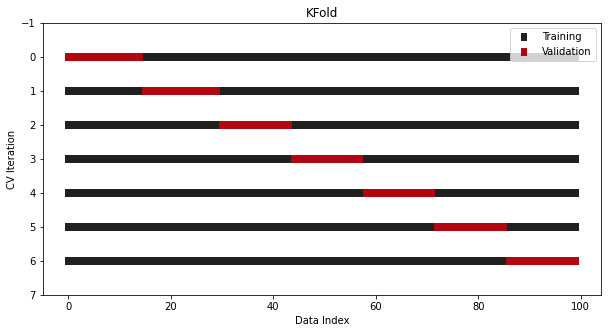

In [75]:
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold

X, y = make_regression(n_samples=100)

# Init the splitter
cv = KFold(n_splits=7)

visualize_cv(cv, X, y)

Great! The chart shows how the hold-out fold (red) is going through the whole data through each iteration. This is a vanilla KFold. 

Another version of this is shuffling the data before a split is performed. This further minimizes the risk of overfitting:

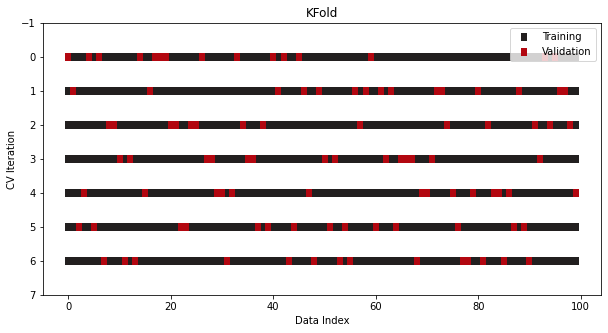

In [76]:
cv = KFold(n_splits=7, shuffle=True)

visualize_cv(cv, X, y)

As you can see, the indices of the validation samples are chosen in a shuffled manner. Even so, the overall number of samples is still one seventh of the whole data because we are doing 7-fold CV.

KFold is the most commonly used CV splitter in practice. It is easy to understand and deadly effective. However, depending on the characteristics of your datasets, sometimes you need to be more picky over what CV procedure to use. So, let's discuss the alternatives.

# 2. StratifiedKFold

Another version of KFold specifically designed for classification problems is `StratifiedKFold`. 

In classification, it is absolutely essential that the distribution of the target is preserved even after the data is split into multiple sets. More specifically, a binary target with 30 to 70 class ratios should still have the same ratios in both the training and test sets. 

Since KFold doesn't care about this or shuffles the data before splitting, the rule is broken. As a solution, we use another splitter class in Sklearn - `StratifiedKFold`:

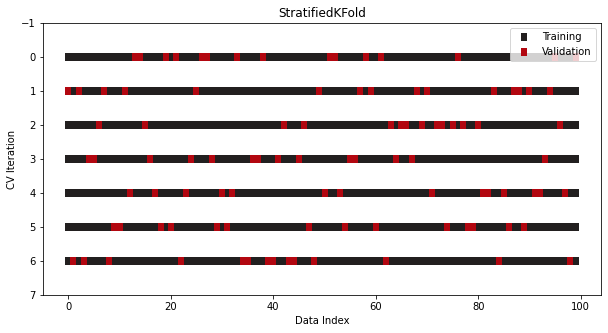

In [84]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

X, y = make_classification(n_samples=100, n_classes=2)

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1121218)

visualize_cv(cv, X, y)

It looks the same as KFold but now class ratios are preserved across all folds and iterations.

# 3. LeavePOut

Sometimes, the data you have is so limited that you can't even afford to divide it into train and test sets. In that case, you can perform a CV where you set aside only a few rows of data in each iteration. This is known as LeavePOut CV, where *p* is the parameter you choose to specify the number of rows in each holdout set. 

The most extreme case is the `LeaveOneOut` splitter where you only use a single row of data as a test set and the number of iterations equals the number of rows in the full data. If building 100 models for a small 100-row dataset seems like it is bordering on crazy, I am right there with ya.

Even for other numbers of `p`, the number of iterations grow exponentially as you dataset size increases. Just image how many models will be built when `p` is 5 and your data has just 50 rows (hint - use the permutations formula). 

So, you rarely see this one in practice but it comes up enough times that there Sklearn implements these procedures:

In [79]:
from sklearn.model_selection import LeaveOneOut, LeavePOut

# 4. ShuffleSplit

How about we don't do CV at all and just repeat the train/test split process multiple times? Well, that's another way you can flirt with the idea of cross-validation and yet still not do it. 

By logic, generating multiple train/test sets using different random seeds should resemble a robust CV process if done for enough iterations. That's why there is a splitter that performs this process in Sklearn:

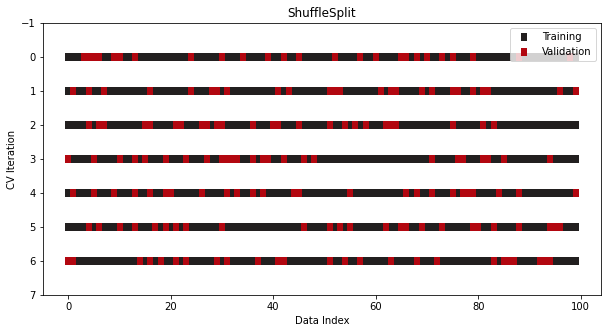

In [85]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=7, train_size=0.75, test_size=0.25)

visualize_cv(cv, X, y)

The advantage of ShuffleSplit is that you have full control over the sizes of train and sets in each fold. In other words, the size of the sets won't be proportionate to the number of splits. 

However, contrary to other splitters, there is no guarantee that random splits will generate different folds in each iteration. So, use the splitter with caution.

By the way, there is also a stratified version of ShuffleSplit for classification:

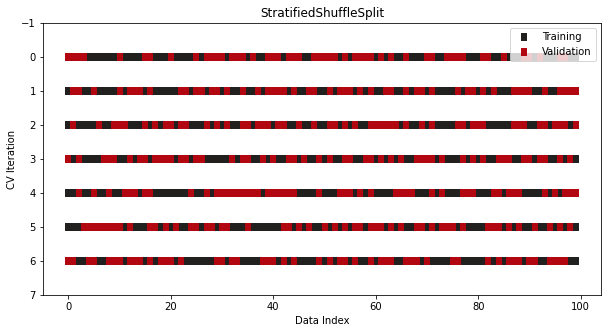

In [86]:
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=7, test_size=0.5)

visualize_cv(cv, X, y)

# 5. TimeSeriesSplit

Finally, we have the special case of time series data where the ordering of samples matter. In fact, the *ordering* is what makes the data time series. 

We can't use any of the traditional splitters because they would lead to a disaster because in each fold you would be training on future and predicting on the past. 

To solve this, Sklearn offers yet another splitter - `TimeSeriesSplit` where it ensures that the above does not happen:

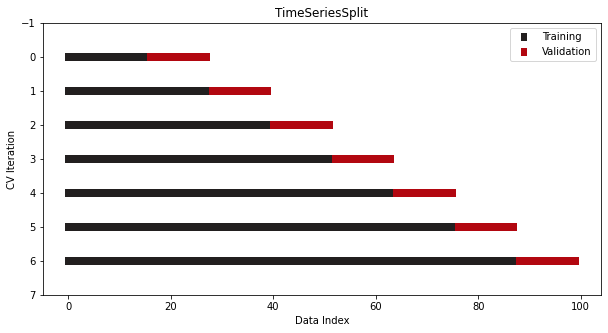

In [87]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=7)

visualize_cv(cv, X, y)

Nice and neat! 

# Other CVs for non-IID data

# Summary